In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

# from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as mse
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,LSTM, Dense, Flatten, Conv1D, Lambda, Reshape
from keras.layers.merge import concatenate, multiply,add
import tensorflow as tf
from keras import regularizers
from keras.initializers import glorot_uniform
from tqdm import tqdm
import rpy2
import rpy2.robjects.numpy2ri
from stldecompose import decompose
rpy2.robjects.numpy2ri.activate()
from rpy2.robjects.packages import importr
from keras import regularizers

from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
stats = importr('stats')
stl=stats.stl
ts =stats.ts
from statsmodels.tsa.seasonal import seasonal_decompose

Using TensorFlow backend.


In [9]:
# d ="/home/chatta/ICML/M3/"
d ="/home/chatta/ICML/nn5/"
data = pd.read_csv(d+"NN5_interpolated.csv",header=None)
predictions = pd.read_csv(d+'final_theta/theta_50_h3.csv',index_col=0,skiprows = [1])
# xls = pd.ExcelFile(d+'M3C.xls')
# data=pd.read_excel(xls,'M3Month')
# data = pd.read_csv(d+"cif_dataset_complete.csv",header=None)
# data = pd.read_csv(d+"NN5_interpolated.csv",header=None)
# predictions = pd.read_csv(d+'theta_25_datafit_Month_h18.csv',index_col=0,skiprows = [1])
# theta1 = pd.read_csv(d+'1st_theta_300.csv',index_col=0)
data_length = data.shape[0]


In [4]:
def make_input(data,window_size,horizon=1):
    length=data.shape[0]
#     depth=data.shape[2]
    y = np.zeros([length-window_size+1-horizon,horizon])
    output=np.zeros([length-window_size+1-horizon,window_size])
    for i in range(length-window_size-horizon+1):
        output[i:i+1,:]=data[i:i+window_size]
        y[i,:]= data[i+window_size:i+window_size+horizon]
    return output.reshape(output.shape[0],window_size,1), y

def make_k_input(data,window_size,horizon):
    length = data.shape[0]
    output= np.zeros([length-window_size+1-horizon,horizon])
    for i in range(length-window_size-horizon+1):
        output[i:i+1,:]=data[i+window_size:i+window_size+horizon]
    return output.reshape(output.shape[0],horizon,1)


In [5]:
def nonov_make_input(data,window_size,horizon=1):
    length=data.shape[0]-window_size
    loop=length//horizon
    extra = length%horizon
#     print(str(extra))
    data = np.append(data,np.zeros([horizon-extra]))
#     print(data)
    if extra ==0:
        i_val = loop
    else:
        i_val=loop+1
        
    output=np.zeros([i_val,window_size])
    y=np.zeros([i_val,horizon])
    for i in range(i_val):
        output[i:i+1,:]=data[i*horizon:(i*horizon)+window_size]
        y[i,:]= data[(i*horizon)+window_size:(i*horizon)+window_size+horizon]
        
    return output.reshape(output.shape[0],window_size,1), y

def nonov_make_k_input(data,window_size,horizon):
    length = data.shape[0]-window_size
    loop=length//horizon
    extra = length%horizon
    data_app = np.repeat(data[-1],extra)
    data = np.append(data,data_app)    
#     data = np.append(data,np.zeros([horizon-extra]))
    if extra ==0:
        i_val = loop
    else:
        i_val=loop+1
    output=np.zeros([i_val,horizon])
    for i in range(i_val):
        output[i:i+1,:]=data[(i*horizon)+window_size:(i*horizon)+window_size+horizon]
    return output.reshape(output.shape[0],horizon,1)    

In [10]:
with tqdm(total=data_length) as pbar:
    for horizon in [1]:
        
        
    
        
        final_predictions = np.zeros([data_length,56])
        for y in range(data_length):
            
#             n_test = data.iloc[y].values[2] #----cif
            n_test = 56
            horizon=56 #-----------check
            
            window_size=25
#             if horizon==6:
#                 window_size=7
#             else:
#                 window_size=15
           
#             nn_val =np.asarray(data.loc[y][3:].dropna().values,dtype=float) #-----cif
            nn_val= np.asarray(data.iloc[y].dropna().values,dtype=float)
            rr = nn_val.size
            rr = int(np.floor(rr*.25))
            temp1=nn_val[2*rr:] #--------------check
#             temp1=np.asarray(data.loc[y].dropna().values,dtype=float)[300:]
           
            epsilon = 0.05
            temp1[temp1<epsilon] = temp1[temp1<epsilon]+0.05
            series = np.log(temp1)
#             series = temp1


            
            frequency = 7   #------------------check            
            if temp1.size < 2*frequency:
                frequency=2
            
            result = stl(ts(series,frequency=frequency),"periodic")
            temp=pandas2ri.ri2py(result.rx2('time.series'))
            series_1  = temp[:,0]+temp[:,2]
            
            t_v_data = series_1[:-n_test]            
            series_length = t_v_data.size
            n_val = int(np.round(series_length*.2))
            if n_val < horizon:
                n_val = horizon
            train = t_v_data[:-n_val]
            if train.size <11:
                window_size=3
            
            test = series_1[-(n_test+window_size):]            

            val = t_v_data[-(n_val+window_size):]
#             resea=temp[:,1][-n_test:]

            

            temp_theta1= np.asarray(predictions.iloc[y].dropna().values,dtype=float)
            temp_theta1[np.argwhere(temp_theta1<=0)]=0.5
            temp_theta1 = np.log(temp_theta1)
            result_k = stl(ts(temp_theta1,frequency=frequency),"periodic")
            temp_theta=pandas2ri.ri2py(result_k.rx2('time.series'))
            series_k_org = temp_theta[:,0]+temp_theta[:,2]
            
        
#             temp_theta= np.log(temp_theta)-temp[:,0]
            temp2= series_k_org[:-n_test]
            test_theta = series_k_org[-(n_test+window_size):]
            resea=temp[:,1][-n_test:]

            
            
            
            temp2_train = temp2[:-n_val]
            temp2_val = temp2[-(n_val+window_size):]            
            train_sequence = make_input(train, window_size,horizon)
            val_sequence = make_input(val,window_size,horizon)
            test_sequence = nonov_make_input(test,window_size,horizon)
            
            k_train = make_k_input(temp2_train,window_size,horizon)
            k_train_input = np.repeat(k_train,window_size,axis=1)            
            k_val = make_k_input(temp2_val,window_size,horizon)
            k_val_input = np.repeat(k_val,window_size,axis=1)
            k_test = nonov_make_k_input(test_theta,window_size,horizon)
            k_test_input = np.repeat(k_test,window_size,axis=1)
            
            x_train = train_sequence[0]#.reshape(train_sequence[0].shape[0],window_size,1)
            y_train =train_sequence[1]#-train_sequence[0][:,window_size-1,:].reshape(train_sequence[0].shape[0],1)
            x_val = val_sequence[0]#-val_sequence[0][:,window_size-1,:].reshape(val_sequence[0].shape[0],1,1)#.reshape(val_sequence[0].shape[0],window_size,1)
            y_val = val_sequence[1]#-val_sequence[0][:,window_size-1,:].reshape(val_sequence[0].shape[0],1)
            x_test = test_sequence[0]#-test_sequence[0][:,window_size-1,:].reshape(test_sequence[0].shape[0],1,1)#.reshape(val_sequence[0].shape[0],window_size,1)
            y_test = test_sequence[1]#-test_sequence[0][:,window_size-1,:].reshape(test_sequence[0].shape[0],1)
            
            train_input = np.append(x_train,k_train,axis=1)#-train_sequence[0][:,window_size-1,:].reshape(train_sequence[0].shape[0],1,1)
            val_input = np.append(x_val,k_val,axis=1)#-val_sequence[0][:,window_size-1,:].reshape(val_sequence[0].shape[0],1,1)
            test_input = np.append(x_test,k_test,axis=1)#-test_sequence[0][:,window_size-1,:].reshape(test_sequence[0].shape[0],1,1)
            
           
            k_train=k_train.reshape(k_train.shape[0],horizon)
            k_val=k_val.reshape(k_val.shape[0],horizon)
            k_test=k_test.reshape(k_test.shape[0],horizon)
            

           

            tf.reset_default_graph()
            K.clear_session()

            inputs_n= Input(batch_shape=(None,window_size+horizon,1),name='input_n')
            inputs_k=Input(batch_shape=(None,horizon),name='input_k')
            branch_0 = Conv1D(64,3, strides=1, padding='same',activation='relu',kernel_initializer=glorot_uniform(1))(inputs_n)
#             branch_1 = branch_0
            branch_0 = Conv1D(64,3, strides=1, padding='same',activation='relu',kernel_initializer=glorot_uniform(1))(branch_0)
#             branch_0 = add([branch_1,branch_0])
            branch_0=Flatten()(branch_0)
            net= Dense(horizon,name='dense_final',activity_regularizer=regularizers.l2(0.03))(branch_0)
            net=add([net,inputs_k])
            #-----------------asdasdasdasdasd----------------------------------
            model=Model(inputs=[inputs_n,inputs_k],outputs=net)
            opt = Adam(lr=0.0001)
            callback = ModelCheckpoint(filepath=d+'nn5.h5',monitor='val_loss',save_best_only=True,save_weights_only=True)

            model.compile(loss='mean_squared_error',
                          optimizer=opt)

            model.fit({'input_n':train_input, 'input_k':k_train},y_train,validation_data=[[val_input,k_val],y_val],callbacks=[callback],batch_size=8,shuffle=True, epochs=75,verbose=0)
#             validation_data=[[test_input,k_test],y_test],callbacks=[callback]
            model.load_weights(d+'nn5.h5')
            pred=model.predict({'input_n':test_input, 'input_k':k_test})
#             pred_final= pred.reshape(n_test)#+test_sequence[0][:,window_size-1,:].reshape(test_sequence[0].shape[0],1))
            pred=pred.reshape(pred.size)[:n_test]
#             helo_temp=pred[0,0]
#             for i in range(pred.shape[0]-2):
#                 helo_temp=np.append(helo_temp,pred[i+1,0])
#             helo_temp = np.append(helo_temp,pred[pred.shape[0]-1,:])
            final_predictions[y,:n_test] = pred.reshape(n_test)
            pbar.update(1)
        np.savetxt(d+'final/50_horg_nonov.csv',final_predictions, fmt='%1.3f',delimiter=',')

100%|██████████| 111/111 [11:13<00:00,  6.07s/it]


In [138]:
[mse(test_theta[-n_test:],test[-n_test:]),mse(pred,test[-n_test:])]

[0.04731991286584695, 0.047422215478297156]

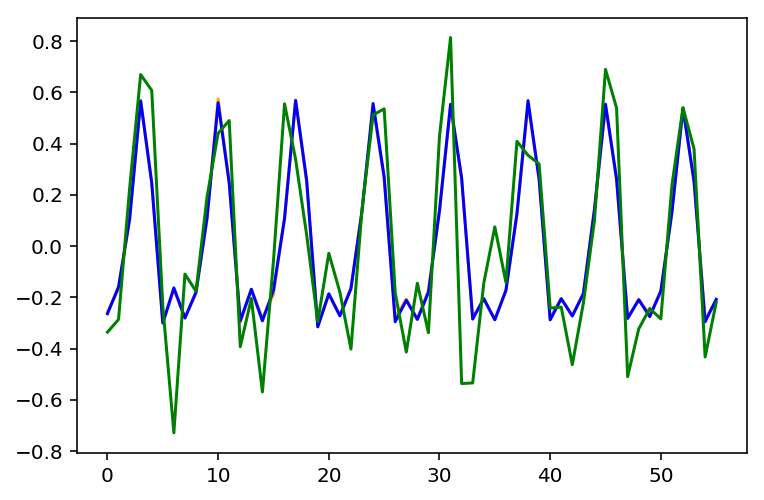

In [139]:
plt.plot(test_theta[-n_test:],color='orange')
plt.plot(pred,color='blue')
plt.plot(test[-(n_test):],color='green')

In [244]:
pred=pred.reshape(pred.size)[:n_test]

In [11]:
final_mape=np.zeros([1,2])
d ="/home/chatta/ICML/CIF2016/"
# temp=0
# for s in ['Year','Quart','Other','Month']:
# xls = pd.ExcelFile(d+'M3C.xls')
# data = pd.read_csv(d+'NN5_interpolated.csv',header=None)
data = pd.read_csv(d+'cif_dataset_complete.csv',header=None)

predictions = pd.read_csv(d+'theta_25_datafit_h1.csv',index_col=0,skiprows = [1])
data_length=data.shape[0]

lstm_k = pd.read_csv(d+'CIF_final_h1_correct.csv',header=None)
mape = np.zeros([data_length,2])
mse_err = np.zeros([data_length,2])
# horizon=56
for i in range(data_length):
    horizon = data.loc[y][1]
    #     if s == 'Year':
#         horizon=6
#     elif s == 'Month':
#         horizon = 18
#     else:
#         horizon = 8

#     temp1=np.asarray(data.loc[i].dropna().values,dtype=float)[300:]

    nn_val =np.asarray(data.loc[i][3:].dropna().values,dtype=float) #-----cif
    rr = nn_val.size
    rr = int(np.floor(rr*.25))
    temp1=nn_val[rr:]
    frequency =12           
    if temp1.size < 2*frequency:
        frequency=7
    epsilon = 0.05
    temp1[temp1<epsilon] = temp1[temp1<epsilon]+0.05
    series = np.log(temp1)
    result = stl(ts(series,frequency=frequency),"periodic")
    temp=pandas2ri.ri2py(result.rx2('time.series'))
    val  = temp[:,0]+temp[:,2]
    val = val[-horizon:]
    zero_indexes = np.argwhere(val==0)
    val =np.delete(val,zero_indexes,None)
    temp_theta1= np.asarray(predictions.iloc[i].dropna().values,dtype=float)
    temp_theta1[np.argwhere(temp_theta1<=0)]=0.5
    temp_theta1 = np.log(temp_theta1)
    result_k = stl(ts(temp_theta1,frequency=frequency),"periodic")
    temp_theta=pandas2ri.ri2py(result_k.rx2('time.series'))
    preds= temp_theta[:,0]+temp_theta[:,2]
    preds=preds[-horizon:]
    preds = np.delete(preds,zero_indexes,None)
#     preds_k = np.asarray(lstm_k.loc[i,:])
    preds_k = np.asarray(lstm_k.iloc[i].values,dtype=float)[:horizon]
    preds_k  = np.delete(preds_k,zero_indexes,None)
#     print(sMAPE(val,preds))

    mape[i,0] = sMAPE(val,preds,horizon)
    mape[i,1] = sMAPE(val,preds_k,horizon)
    mse_err[i,0] = mse(val,preds)
    mse_err[i,1] =mse(val,preds_k)
#         print(mape.shape)
#     break
avg_mape  = np.sum(mape,axis=0)/data_length
avg_mse  = np.sum(mse_err,axis=0)/data_length

#         print(avg_mape.shape)
#         break
final_mape[0,:] = avg_mape
# temp+=1
final_avg_mape = np.sum(final_mape,axis=0)/final_mape.shape[0]

In [12]:
avg_mape

array([1.6173557, 1.4380546])

In [12]:
preds_k

array([-0.008,  0.003,  0.005, -0.003,  0.011,  0.001,  0.001,  0.003,
       -0.01 , -0.008,  0.005,  0.009,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ])

In [66]:
18*3

54

In [221]:
mse(pred_final,temp1[-n_test:])

26.921728460241734

In [8]:
def sMAPE(val,preds,horizon):
    temp = np.abs(val-preds)
    temp1=np.abs(val)+np.abs(preds)
    
    smape = 2/horizon*np.sum(temp/temp1)

    return smape

In [160]:
sMAPE(temp1[-n_test:],np.exp(temp_theta1[-n_test:]))

0.03126377375932253

In [ ]:
mape = np.zeros([data_length])
for i in range(data_length):
    
    val=np.asarray(data.loc[i][6:].dropna().values,dtype=float)[-6:]
    preds=final_predictions[i,:]
#     print(sMAPE(val,preds))
    mape[i] = sMAPE(val,preds)
#     print(mape[i])
#     break
avg_mape  = np.sum(mape)/data_length
avg_mape